# Demographic Exposures

For this analysis I use block and block group level data to calculate an exposure rate per capita for every block.  That is determined by looking at the number of seconds a drone spent in a block and multiplying it by the number of people in the block.  

Overall, the poorer the neighborhood, the more exposure to drones its residents faced. Residents in the working class and largely immigrant West side of Chula Vista were far more likely to be exposed to police drone cameras compared to those in the wealthier communities on the East side. According to our analysis, drones lingered in the sky above the average West side block for a total of nearly two hours—more than five times as high as the average block on the East side.  Latine residents, who make up 70 percent of Chula Vista's population, faced 1.6 times as much exposure per capita as non-Latine residents did. 


In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
from loguru import logger
storage = "/Volumes/easystore/Drones/"

from shapely import wkt
import json

cv_flights = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_cv-flight-manifest.csv",
                chunksize=100000,
                dtype=str,
            ),
            desc="Loading data",
        )
    ]
)
per_second = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_drone-seconds-block-count.csv",
                chunksize=100000,
                dtype=str,
            ),
            desc="Loading data",
        )
    ]
)


race_df = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_census-race.csv",
                chunksize=100000,
                dtype=str,
            ),
            desc="Loading data",
        )
    ]
)
poverty_df = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_acs-poverty-blockgroups.csv",
                chunksize=100000,
                dtype=str,
            ),
            desc="Loading data",
        )
    ]
)
cv_blocks = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_cv-blocks-geometry.csv",
                chunksize=100000,
                dtype=str,
            ),
            desc="Loading data",
        )
    ]
)

# flight_data = pd.read_csv("/Volumes/easystore/Drones/compiled-flight-data-gpx.csv",dtype=str)
# flight_data.head()
def wkt_to_geojson(wkt_str):
    geom = wkt.loads(wkt_str)
    coordinates = [list(coord) for coord in geom.exterior.coords]
    geojson = {
        "type": "Polygon",
        "coordinates": [coordinates]
    }
    return json.dumps(geojson)

# Apply the conversion to the geometry column

Loading data: 0it [00:00, ?it/s]

Loading data: 0it [00:00, ?it/s]

Loading data: 0it [00:00, ?it/s]

Loading data: 0it [00:00, ?it/s]

Loading data: 0it [00:00, ?it/s]

## Prepare Data


In [3]:
per_second["seconds"] = per_second["seconds"].astype(float)
per_second["call_count"] = per_second["call_count"].astype(float)
per_second["block-group-geoid"] = cv_blocks['GEOID20'].apply(lambda x: x[:12])


In [4]:
per_second_joined_race = pd.merge(per_second, race_df, on="GEOID20", how="left")

In [5]:
per_second_joined_race['population_exposure'] = (per_second_joined_race['POP20'].astype(float)*per_second_joined_race['seconds'])
per_second_joined_race['population_exposure_ctrl_size'] = (per_second_joined_race['POP20'].astype(float)*per_second_joined_race['seconds'])/per_second_joined_race['ALAND20'].astype(float)
per_second_joined_race['block_exposure_ctrl_size'] = (per_second_joined_race['seconds'])/per_second_joined_race['ALAND20'].astype(float)
per_second_joined_race['block_exposure_ctrl_population'] = (per_second_joined_race['seconds'])/per_second_joined_race['POP20'].astype(float)

per_second_joined_race.to_csv('./geometries-for-flourish-test1.csv',index=False)



In [6]:
coi = ['GEOID20','ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'HOUSING20', 'POP20',
       'geometry', 'seconds', 'weight', 'call_count',
       'block-group-geoid', 'Geography', 'Geographic Area Name', 'Total_x',
       'Total Alone', 'Total Latino', 'Total Not Latino', 'Total White',
       'Total Black or African American',
       'Total American Indian and Alaska Native', 'Total Asian',
       'Total Native Hawaiian and Other Pacific Islander',
       'Total Some Other Race','population_exposure',
       'population_exposure_ctrl_size', 'block_exposure_ctrl_size','Total_y','FRLP Households','Below Median Households', '% FRLP Eligible', '% Below Median','west_cv']

In [7]:
analysis_df = pd.merge(per_second_joined_race,poverty_df,on='block-group-geoid',how='left')

## Flourish Addendum

In [9]:
analysis_df['hours'] = analysis_df['seconds'].astype(int)/3600

analysis_df.to_csv('../viz/analysis_df.csv',index=False)

## East versus West

Comparing Blocks on the East Versus the West.  Measure the total number of exposures on each block in the west and the east. then divide by the total population of all the blocks in west versus the east.  Then compare



In [137]:
west_cv = analysis_df[analysis_df['west_cv']=='True'].copy()
east_cv = analysis_df[analysis_df['west_cv']=='False'].copy()


In [138]:
west_cv.head()

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,...,"75,000 to 99,999","100,000 to 124,999","125,000 to 149,999","150,000 to 199,999","200,000 or more",len,FRLP Households,Below Median Households,% FRLP Eligible,% Below Median
0,6,73,12600,1005,060730126001005,Block 1005,G5040,U,78661.0,U,...,14,27,16,0,0,19,229.0,252.0,0.7762711864406779,0.8542372881355932
1,6,73,12600,1000,060730126001000,Block 1000,G5040,U,78661.0,U,...,14,27,16,0,0,19,229.0,252.0,0.7762711864406779,0.8542372881355932
2,6,73,12600,1001,060730126001001,Block 1001,G5040,U,78661.0,U,...,14,27,16,0,0,19,229.0,252.0,0.7762711864406779,0.8542372881355932
3,6,73,12600,1002,060730126001002,Block 1002,G5040,U,78661.0,U,...,14,27,16,0,0,19,229.0,252.0,0.7762711864406779,0.8542372881355932
4,6,73,12600,1003,060730126001003,Block 1003,G5040,U,78661.0,U,...,14,27,16,0,0,19,229.0,252.0,0.7762711864406779,0.8542372881355932


### Exposures per Capita 

In [139]:
west_cv['total_exposures'] = west_cv['POP20'].astype(float)*west_cv['seconds'].astype(float)
western_exposures_per_capita = west_cv['total_exposures'].sum()/west_cv['Total_x'].astype(float).sum()

In [140]:
east_cv['total_exposures'] = east_cv['POP20'].astype(float)*east_cv['seconds'].astype(float)
eastern_exposures_per_capita = east_cv['total_exposures'].sum()/east_cv['Total_x'].astype(float).sum()

In [141]:
logger.info(f"Western Exposures per Capita {western_exposures_per_capita} ")
logger.info(f"Eastern Exposures per Capita {eastern_exposures_per_capita} ")
logger.info(f"Western Exposures were {western_exposures_per_capita/eastern_exposures_per_capita} as high as eastern Exposures per Capita  ")


2024-05-23 11:13:34.900 | INFO     | __main__:<module>:1 - Western Exposures per Capita 21368.394391589725 
2024-05-23 11:13:34.902 | INFO     | __main__:<module>:2 - Eastern Exposures per Capita 4327.400986101806 
2024-05-23 11:13:34.903 | INFO     | __main__:<module>:3 - Western Exposures were 4.937927975756812 as high as eastern Exposures per Capita  


### Hours Surveilled

In [142]:

logger.info(f"According to our analysis, drones hovered over the typical West side block {(west_cv['seconds'].median()/3600) / (east_cv['seconds'].median()/3600) -1} times longer than over the typical East side block.")

2024-05-23 11:13:35.222 | INFO     | __main__:<module>:1 - According to our analysis, drones hovered over the typical West side block 9.900584795321638 times longer than over the typical East side block.


## Free Reduced Lunch Analysis

In [143]:
poor_bgs = analysis_df[analysis_df['% FRLP Eligible'].astype(float) >= .5].copy()
poor_bgs['total_exposures'] = poor_bgs['Total_x'].astype(float)*poor_bgs['seconds'].astype(float)
poor_bgs['total_exposures'].sum()/poor_bgs['Total_x'].astype(float).sum()

over_50_frl = poor_bgs['total_exposures'].sum()/poor_bgs['POP20'].astype(float).sum()

less_poor = analysis_df[analysis_df['% FRLP Eligible'].astype(float) <= .5].copy()
less_poor['total_exposures'] = less_poor['Total_x'].astype(float)*less_poor['seconds'].astype(float)

under_50_frl = less_poor['total_exposures'].sum()/less_poor['POP20'].astype(float).sum()


In [144]:
logger.info(f"Exposure for Population on BGs where half of households are eligible for FRL {over_50_frl}")
logger.info(f"Exposure for Population on BGs where half of households are eligible for FRL {under_50_frl}")
logger.info(f"People in these blocks are {over_50_frl/under_50_frl} times as exposed")


2024-05-23 11:13:35.703 | INFO     | __main__:<module>:1 - Exposure for Population on BGs where half of households are eligible for FRL 29550.499261190787
2024-05-23 11:13:35.704 | INFO     | __main__:<module>:2 - Exposure for Population on BGs where half of households are eligible for FRL 6550.991214613823
2024-05-23 11:13:35.705 | INFO     | __main__:<module>:3 - People in these blocks are 4.510843976598551 times as exposed


In [145]:
logger.info(f"Western Mean {poor_bgs['seconds'].mean()/3600} hours")
logger.info(f"Western Medizn {poor_bgs['seconds'].median()/3600} hours")
logger.info(f"Eastern Mean {less_poor['seconds'].mean()/3600} hours")
logger.info(f"Eastern Median {less_poor['seconds'].median()/3600} hours")


2024-05-23 11:13:35.870 | INFO     | __main__:<module>:1 - Western Mean 2.565797564687976 hours
2024-05-23 11:13:35.873 | INFO     | __main__:<module>:2 - Western Medizn 0.66 hours
2024-05-23 11:13:35.874 | INFO     | __main__:<module>:3 - Eastern Mean 0.6324053070083315 hours
2024-05-23 11:13:35.876 | INFO     | __main__:<module>:4 - Eastern Median 0.10055555555555555 hours


## Graph of Exposure Per Capita per Decile

In [146]:
graph = []
for decile in [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]:
    dec = {}
    df = analysis_df[analysis_df['% Below Median'].astype(float) <= decile].copy()
    
    dec['decile'] = decile
    dec['per_capita_exposure'] = df['population_exposure'].sum()/df['Total_x'].astype(float).sum()
    graph.append(dec)
    

In [147]:
graph = pd.DataFrame(graph)

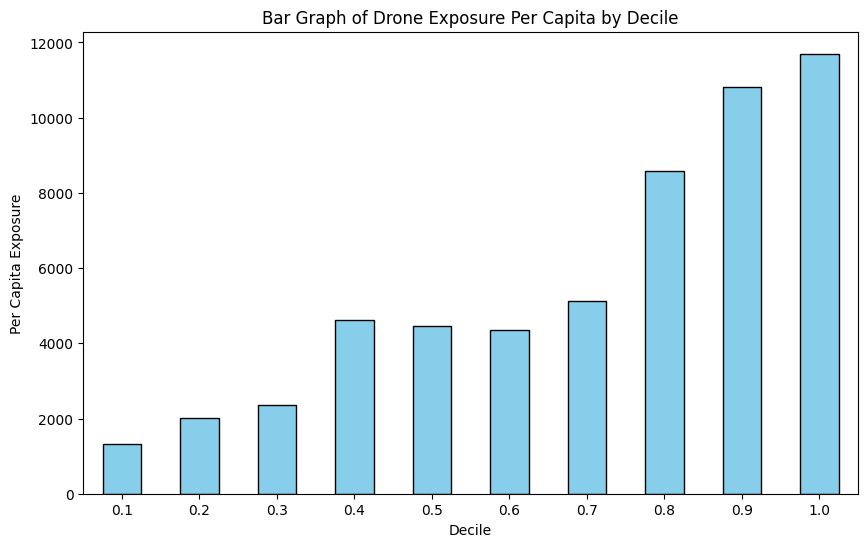

2024-05-23 11:13:36.544 | INFO     | __main__:<module>:13 - This Graph Shows that at the Percentages of Households earning less than the median Chula Vista Household increases in a neighborhood, the exposure to the drones increases


In [148]:
import matplotlib.pyplot as plt

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(graph['decile'], graph['per_capita_exposure'], color='skyblue', edgecolor='black', width=0.05)
plt.xlabel('Decile')
plt.ylabel('Per Capita Exposure')
plt.title('Bar Graph of Drone Exposure Per Capita by Decile')
plt.xticks(graph['decile'])  # Set x-ticks to match the deciles
plt.xlim(0.05, 1.05)  # Set the limits for the x-axis to accommodate uniform bar width
plt.show()

logger.info("This Graph Shows that at the Percentages of Households earning less than the median Chula Vista Household increases in a neighborhood, the exposure to the drones increases")

## Demographic Exposures

In [149]:
graph = []
for x in ['Total Alone', 'Total Latino', 'Total Not Latino', 'Total White','Total Black or African American','Total American Indian and Alaska Native', 'Total Asian','Total Native Hawaiian and Other Pacific Islander','Total Some Other Race']:
    
    dec = {}
    dec['demographic'] = x
    analysis_df[f'{x}_demo_exposure'] = (analysis_df[x].astype(float) * analysis_df['seconds'].astype(float))
   
    dec['per_capita_exposure'] = analysis_df[f'{x}_demo_exposure'].sum()/analysis_df[x].astype(float).sum()
    graph.append(dec)

In [150]:
graph

[{'demographic': 'Total Alone', 'per_capita_exposure': 8622.64454525893},
 {'demographic': 'Total Latino', 'per_capita_exposure': 13631.60787325331},
 {'demographic': 'Total Not Latino', 'per_capita_exposure': 8428.557667460324},
 {'demographic': 'Total White', 'per_capita_exposure': 9313.006455481163},
 {'demographic': 'Total Black or African American',
  'per_capita_exposure': 12232.117264057875},
 {'demographic': 'Total American Indian and Alaska Native',
  'per_capita_exposure': 6927.385737439222},
 {'demographic': 'Total Asian', 'per_capita_exposure': 6451.63974593755},
 {'demographic': 'Total Native Hawaiian and Other Pacific Islander',
  'per_capita_exposure': 10397.247787610619},
 {'demographic': 'Total Some Other Race',
  'per_capita_exposure': 10990.283731688512}]

In [151]:
logger.info(f"Latinos are {13631.60787325331/8428.557667460324} as exoposed as non latinos")

2024-05-23 11:13:37.099 | INFO     | __main__:<module>:1 - Latinos are 1.617312049234725 as exoposed as non latinos


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Total Asian'),
  Text(1, 0, 'Total American Indian and Alaska Native'),
  Text(2, 0, 'Total Not Latino'),
  Text(3, 0, 'Total Alone'),
  Text(4, 0, 'Total White'),
  Text(5, 0, 'Total Native Hawaiian and Other Pacific Islander'),
  Text(6, 0, 'Total Some Other Race'),
  Text(7, 0, 'Total Black or African American'),
  Text(8, 0, 'Total Latino')])

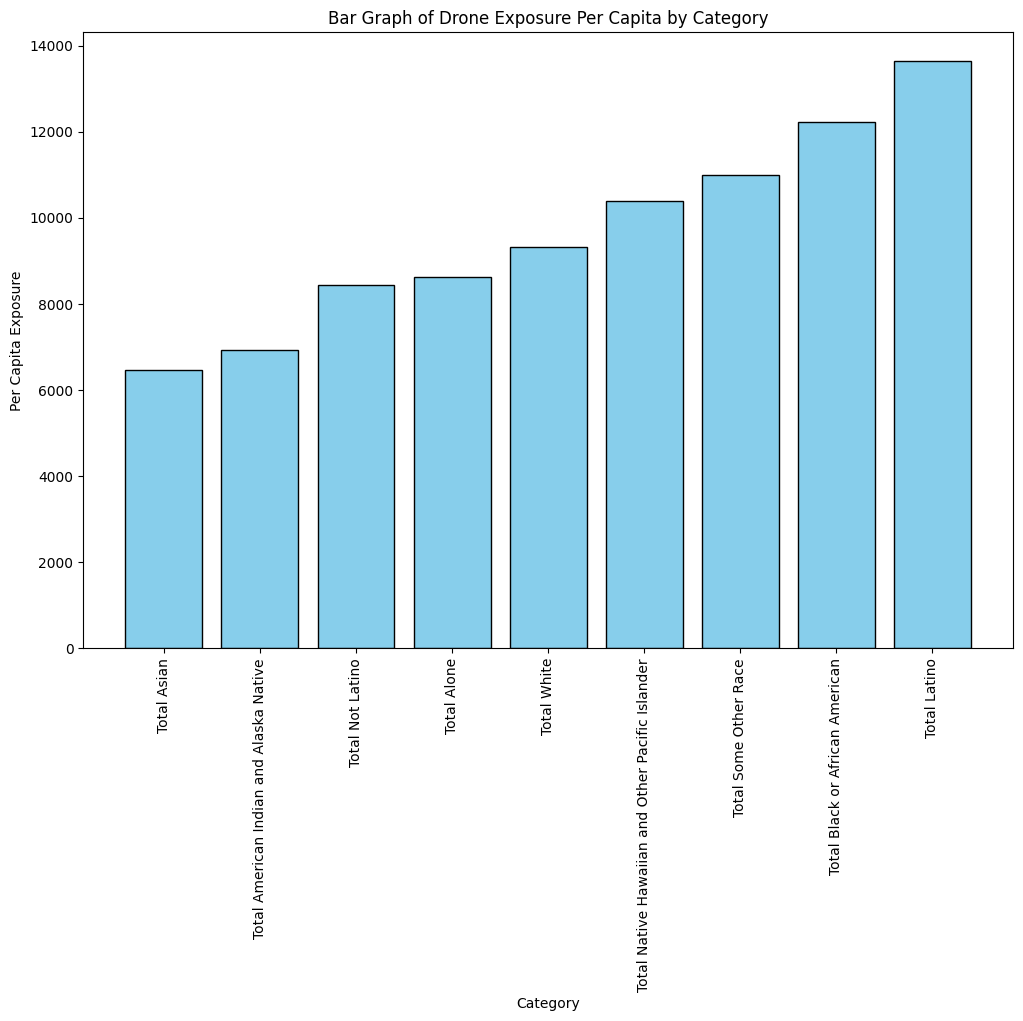

In [152]:
graph = pd.DataFrame(graph).sort_values('per_capita_exposure')
plt.figure(figsize=(12, 8))
plt.bar(graph['demographic'], graph['per_capita_exposure'], color='skyblue', edgecolor='black')
plt.xlabel('Category')
plt.ylabel('Per Capita Exposure')
plt.title('Bar Graph of Drone Exposure Per Capita by Category')
plt.xticks(rotation=90)  # Rotate the x-axis labels to 90 degrees for full readability
